In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, ReLU, Dropout,
                                     MaxPooling1D, GlobalAveragePooling1D, Dense, Add)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, roc_auc_score

# === Load CSVs ===
signal_bbh = pd.read_csv("./dataset/raw-data-files-enhanced-data-generation/Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", header=None).astype(float)
noise = pd.read_csv("./dataset/raw-data-files-enhanced-data-generation/Final_Merged_Noise_Reduced_No_Abs.csv", header=None).astype(float)
val_signal_bbh = pd.read_csv("./dataset/raw-val-data-files-enhanced-data-generation/val_Final_BBH_Merged_Noise_Signal_Reduced_No_ABS.csv", header=None).astype(float)
val_noise = pd.read_csv("./dataset/raw-val-data-files-enhanced-data-generation/val_Final_Merged_Noise_Reduced_No_Abs.csv", header=None).astype(float)

signal_bbh["label"] = 1
noise["label"] = 0
val_signal_bbh["label"] = 1
val_noise["label"] = 0

# === Merge, Shuffle, Scale ===
train_data = shuffle(pd.concat([signal_bbh, noise], axis=0).reset_index(drop=True), random_state=42)
val_data = shuffle(pd.concat([val_signal_bbh, val_noise], axis=0).reset_index(drop=True), random_state=42)

scaler = StandardScaler()
scaler.fit(noise.iloc[:, :-1])  # scale only on pure noise
np.save("scaler_mean.npy", scaler.mean_)
np.save("scaler_scale.npy", scaler.scale_)

X_train = scaler.transform(train_data.iloc[:, :-1])
y_train = train_data.iloc[:, -1].values.astype(np.float32)

X_val = scaler.transform(val_data.iloc[:, :-1])
y_val = val_data.iloc[:, -1].values.astype(np.float32)

X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

Epoch 1/30
313/313 [==============================] - 22s 63ms/step - loss: 0.5916 - accuracy: 0.6755 - val_loss: 2.3540 - val_accuracy: 0.5000
Epoch 2/30
313/313 [==============================] - 20s 65ms/step - loss: 0.4571 - accuracy: 0.7887 - val_loss: 3.9632 - val_accuracy: 0.5000
Epoch 3/30
313/313 [==============================] - 20s 62ms/step - loss: 0.4098 - accuracy: 0.8181 - val_loss: 0.5143 - val_accuracy: 0.7315
Epoch 4/30
313/313 [==============================] - 19s 60ms/step - loss: 0.3822 - accuracy: 0.8315 - val_loss: 16.4919 - val_accuracy: 0.5000
Epoch 5/30
313/313 [==============================] - 20s 64ms/step - loss: 0.3584 - accuracy: 0.8441 - val_loss: 0.8053 - val_accuracy: 0.6250
Epoch 6/30
313/313 [==============================] - 19s 60ms/step - loss: 0.3452 - accuracy: 0.8531 - val_loss: 0.4462 - val_accuracy: 0.7885
Epoch 7/30
313/313 [==============================] - 60s 193ms/step - loss: 0.3140 - accuracy: 0.8677 - val_loss: 0.7469 - val_accurac

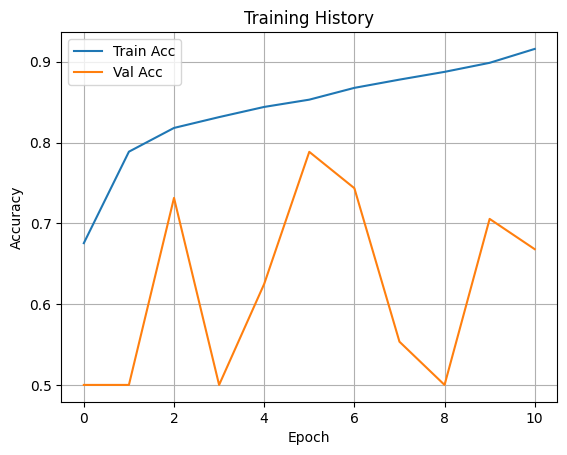

In [4]:
# === CNN Model Definition ===
def build_deep_cnn(input_shape=(16384, 1)):
    inputs = Input(shape=input_shape)

    x = Conv1D(32, 16, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)

    x = Conv1D(64, 8, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)

    x = Conv1D(128, 8, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(256, 8, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(4)(x)
    x = Dropout(0.4)(x)

    x = Conv1D(512, 4, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# === Build & Train ===
model = build_deep_cnn()
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# === Evaluate ===
y_pred = model.predict(X_val).ravel()
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

# === Plot Accuracy ===
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [5]:
model.save('synthetic_model.h5')

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
